# Hybrid Model

Importing libraries and creating the global variables:

In [1]:
%load_ext autoreload
%autoreload 2

from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.pipeline import Pipeline
from dateutil.relativedelta import relativedelta
from chronos import ChronosPipeline
from darts.models import TiDEModel
from darts import TimeSeries
import pandas as pd
pd.options.mode.chained_assignment = None
import torch
torch.set_float32_matmul_precision('high')
import utils

import warnings
warnings.filterwarnings("ignore")

DATASET = "hf://datasets/zaai-ai/time_series_datasets/data.csv"
RESIDUALS_DATASET = "hf://datasets/zaai-ai/time_series_dataset_residuals/residuals.csv"

SAVE = False
LOAD = True
NUM_FOLDS = 4


TIME_COL = "Date"
TARGET = "visits"
RESIDUALS_TARGET = "residuals"
STATIC_COV = ["static_1", "static_2", "static_3", "static_4"]
DYNAMIC_COV = ["CPI", "Inflation_Rate", "GDP"]

FORECAST_HORIZON = 6 # months
FREQ = "MS"

SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])


CHRONOS_ARCHITECTURE = ("amazon/chronos-t5-large","cuda")

Loading the dataset and verifying the data:

In [2]:
# load data
df = pd.read_csv(DATASET).drop(columns=["Unnamed: 0"])
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = df[TARGET].replace(0.0, 0.01)
df[TARGET] = df[TARGET].round(2)

In [3]:
print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df

Distinct number of time series: 304


,Date,unique_id,visits,CPI,Inflation_Rate,GDP,static_1,static_2,static_3,static_4
0,1998-01-01,AAAHol,2015.44,67.4,0.009,3.996740e+11,A,A,A,Hol
1,1998-02-01,AAAHol,514.34,67.4,0.009,3.996740e+11,A,A,A,Hol
2,1998-03-01,AAAHol,532.10,67.4,0.009,3.996740e+11,A,A,A,Hol
3,1998-04-01,AAAHol,534.06,67.4,0.009,3.996740e+11,A,A,A,Hol
4,1998-05-01,AAAHol,505.22,67.4,0.009,3.996740e+11,A,A,A,Hol
...,...,...,...,...,...,...,...,...,...,...
69109,2016-08-01,GBDOth,0.01,109.1,0.013,1.207580e+12,G,B,D,Oth
69110,2016-09-01,GBDOth,0.01,109.1,0.013,1.207580e+12,G,B,D,Oth
69111,2016-10-01,GBDOth,0.01,109.1,0.013,1.207580e+12,G,B,D,Oth
69112,2016-11-01,GBDOth,0.01,109.1,0.013,1.207580e+12,G,B,D,Oth


In [4]:
print(f"Initial date: {df[TIME_COL].min()}")
end_date = df[TIME_COL].max()
print(f"End date: {end_date}\n")

print(f"25 percentile date: {df[TIME_COL].quantile(0.25)}\n")

# Total of years
print(f"Total of years: {round((end_date-df[TIME_COL].min()).days / 365.25, 2)}")

Initial date: 1998-01-01 00:00:00
End date: 2016-12-01 00:00:00

25 percentile date: 2002-10-01 00:00:00

Total of years: 18.92


Creating the folds for the cross-validation:

In [5]:
folds = []
for i in range(NUM_FOLDS, 0, -1):
    start_date = end_date - relativedelta(months=FORECAST_HORIZON*i)
    end_date_fold = start_date + relativedelta(months=FORECAST_HORIZON)

    fold = {
        "start_date": start_date,
        "end_date": end_date_fold,
        "train": None,
        "test": None,
        "df": None,
        "predictions": {
            "chronos": None,
            "tide": None,
            "hybrid": {
                "default": None,
                "tuned": None
            }
        }
    }

    fold["train"] = df[df[TIME_COL] <= fold["start_date"]]
    fold["test"] = df[(df[TIME_COL] > fold["start_date"]) & (df[TIME_COL] <= fold["end_date"])]
    fold["df"] = df[df[TIME_COL] <= fold["end_date"]]
    folds.append(fold)
    
    
for i,fold in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"Months for training: {len(fold['train'][TIME_COL].unique())} from {min(fold['train'][TIME_COL]).date()} to {max(fold['train'][TIME_COL]).date()}")
    print(f"Months for testing: {len(fold['test'][TIME_COL].unique())} from {min(fold['test'][TIME_COL]).date()} to {max(fold['test'][TIME_COL]).date()}\n")

Fold 1:
Months for training: 204 from 1998-01-01 to 2014-12-01
Months for testing: 6 from 2015-01-01 to 2015-06-01

Fold 2:
Months for training: 210 from 1998-01-01 to 2015-06-01
Months for testing: 6 from 2015-07-01 to 2015-12-01

Fold 3:
Months for training: 216 from 1998-01-01 to 2015-12-01
Months for testing: 6 from 2016-01-01 to 2016-06-01

Fold 4:
Months for training: 222 from 1998-01-01 to 2016-06-01
Months for testing: 6 from 2016-07-01 to 2016-12-01



## Chronos

Forecasting using the Chronos model:

In [6]:
if LOAD:
    print("Loading Chronos folds predictions...\n")
    for i in range(4):
        folds[i]['predictions']['chronos'] = pd.read_csv(f'data/chronos_forecast_fold{i+1}.csv')
        folds[i]['predictions']['chronos'][TIME_COL] = pd.to_datetime(folds[i]['predictions']['chronos'][TIME_COL])
else:
    print("Executing Chronos folds predictions...\n")
    for i,fold in enumerate(folds):
        train_darts = TimeSeries.from_group_dataframe(
                df=fold['train'],
                group_cols=STATIC_COV,
                time_col=TIME_COL,
                value_cols=TARGET,
                freq=FREQ,
                fill_missing_dates=True,
                fillna_value=0)
            
        # Load the Chronos pipeline
        pipeline = ChronosPipeline.from_pretrained(
            CHRONOS_ARCHITECTURE[0],
            device_map=CHRONOS_ARCHITECTURE[1],
            torch_dtype=torch.bfloat16)
        
        forecast = []
        for ts in train_darts:
            # Forecast
            lower, mid, upper = utils.chronos_forecast(pipeline, ts.pd_dataframe().reset_index(), FORECAST_HORIZON, TARGET)
            unique_id = "".join(str(ts.static_covariates[key].item()) for key in ts.static_covariates)
            forecast.append(utils.convert_forecast_to_pandas([lower, mid, upper], fold['test'][fold['test']['unique_id'] == unique_id]))
            
        fold['predictions']['chronos'] = pd.concat(forecast)
        if SAVE:
            print("Saving Chronos folds predictions...\n")
            fold['predictions']['chronos'].to_csv(f'data/chronos_forecast_fold{i+1}.csv', index=False)

Loading Chronos folds predictions...



### Hybrid Model

Here we combine Chronos and TiDE: using chronos residuals to train TiDE and then combine the predicted residuals with the original chronos forecast.

In [9]:
# RMSE: 133.85
tuned_TiDE_params= {
    'input_chunk_length': 11,
    'output_chunk_length': FORECAST_HORIZON,
    'num_encoder_layers': 5,
    'num_decoder_layers': 10,
    'decoder_output_dim': 15,
    'hidden_size': 5,
    'temporal_width_past': 4,
    'temporal_width_future': 10,
    'temporal_decoder_hidden': 20,
    'dropout': 0.15,
    'batch_size': 128,
    'n_epochs': 30,
    'likelihood': QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    'random_state': 42,
    'use_static_covariates': True,
    'optimizer_kwargs': {'lr': 0.001},
    'use_reversible_instance_norm': True,
}

In [10]:
if LOAD:
    print("Loading Chronos+TiDE folds predictions...\n")
    for i in range(4):
        folds[i]['predictions']['hybrid']['default'] = pd.read_csv(f'data/chronos_tide_default_forecast_fold{i+1}.csv')
        folds[i]['predictions']['hybrid']['default'][TIME_COL] = pd.to_datetime(folds[i]['predictions']['hybrid']['default'][TIME_COL])
        folds[i]['predictions']['hybrid']['tuned'] = pd.read_csv(f'data/chronos_tide_tuned_forecast_fold{i+1}.csv')
        folds[i]['predictions']['hybrid']['tuned'][TIME_COL] = pd.to_datetime(folds[i]['predictions']['hybrid']['tuned'][TIME_COL])
else:
    residuals = pd.read_csv(RESIDUALS_DATASET)
    residuals[TIME_COL] = pd.to_datetime(residuals[TIME_COL])
    
    for i,fold in enumerate(folds):
        residuals_train = residuals[residuals[TIME_COL] <= fold['start_date']]
        residuals_df = residuals[(residuals[TIME_COL] <= fold['end_date'])]
        
        residuals_darts = TimeSeries.from_group_dataframe(
            df=residuals_train,
            group_cols=STATIC_COV,
            time_col=TIME_COL,
            value_cols=RESIDUALS_TARGET,
            freq=FREQ,
            fill_missing_dates=True,
            fillna_value=0)
        
        dynamic_covariates = utils.create_dynamic_covariates(residuals_darts,residuals_df,FORECAST_HORIZON, DYNAMIC_COV)
        
        # scale covariates
        dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
        
        # scale data and transform static covariates
        data_transformed = PIPELINE.fit_transform(residuals_darts)
        
        # Default Model
        residuals_tide = TiDEModel(**TiDE_params)
        residuals_tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
        pred = PIPELINE.inverse_transform(residuals_tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))    
        residuals_forecast = utils.transform_predictions_to_pandas(pred, RESIDUALS_TARGET, residuals_darts, [0.25, 0.5, 0.75], convert=False)
        fold['predictions']['hybrid']['default'] = utils.combine_predictions(fold['predictions']['chronos'], residuals_forecast)
        if SAVE:
            print("Saving Chronos+TiDE default folds predictions...\n")
            fold['predictions']['hybrid']['default'].to_csv(f'data/chronos_tide_default_forecast_fold{i+1}.csv', index=False)
        
        # Tuned Model
        residuals_tide = TiDEModel(**tuned_TiDE_params)
        residuals_tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
        pred = PIPELINE.inverse_transform(residuals_tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
        residuals_forecast = utils.transform_predictions_to_pandas(pred, RESIDUALS_TARGET, residuals_darts, [0.25, 0.5, 0.75], convert=False)
        fold['predictions']['hybrid']['tuned'] = utils.combine_predictions(fold['predictions']['chronos'], residuals_forecast)
        if SAVE:
            print("Saving Chronos+TiDE tuned folds predictions...\n")
            fold['predictions']['hybrid']['tuned'].to_csv(f'data/chronos_tide_tuned_forecast_fold{i+1}.csv', index=False)

Loading Chronos+TiDE folds predictions...



## TiDE
Forecasting using the TiDE model:

In [7]:
TiDE_params= {
    'input_chunk_length': 12,
     'output_chunk_length': FORECAST_HORIZON,
     'num_encoder_layers': 4,
     'num_decoder_layers': 8,
     'decoder_output_dim': 8,
     'hidden_size': 8,
     'temporal_width_past': 16,
     'temporal_width_future': 8,
     'temporal_decoder_hidden': 128,
     'dropout': 0.2,
     'batch_size': 16,
     'n_epochs': 20,
     'likelihood': QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
     'random_state': 42,
     'use_static_covariates': True,
     'optimizer_kwargs': {'lr': 0.001},
     'use_reversible_instance_norm': False
}

In [8]:
if LOAD:
    print("Loading TiDE folds predictions...\n")
    for i in range(4):
        folds[i]['predictions']['tide'] = pd.read_csv(f'data/tide_forecast_fold{i+1}.csv')
        folds[i]['predictions']['tide'][TIME_COL] = pd.to_datetime(folds[i]['predictions']['tide'][TIME_COL])
else:
    print("Executing TiDE folds predictions...\n")
    for i,fold in enumerate(folds):    
        train_darts = TimeSeries.from_group_dataframe(
                df=fold['train'],
                group_cols=STATIC_COV,
                time_col=TIME_COL,
                value_cols=TARGET,
                freq=FREQ,
                fill_missing_dates=True,
                fillna_value=0)
        
        dynamic_covariates = utils.create_dynamic_covariates(train_darts,fold['df'],FORECAST_HORIZON,DYNAMIC_COV)
        
        # scale covariates
        dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)
        
        # scale data and transform static +covariates
        data_transformed = PIPELINE.fit_transform(train_darts)
        
        tide = TiDEModel(**TiDE_params)
        tide.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
        pred = PIPELINE.inverse_transform(tide.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))    
        fold['predictions']['tide'] = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])
        if SAVE:
            print("Saving TiDE folds predictions...\n")
            fold['predictions']['tide'].to_csv(f'data/tide_forecast_fold{i+1}.csv', index=False)

Loading TiDE folds predictions...



# Evaluation

In [11]:
chronos_forecasts = []
tide_forecasts = []
hybrid_forecasts_default = []
hybrid_forecasts_tuned = []
tests = []

for i,fold in enumerate(folds):
    chronos_forecasts.append(fold['predictions']['chronos'])
    tide_forecasts.append(fold['predictions']['tide'])
    hybrid_forecasts_default.append(fold['predictions']['hybrid']['default'])
    hybrid_forecasts_tuned.append(fold['predictions']['hybrid']['tuned'])
    tests.append(fold['test'])

In [12]:
top_25 = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET,ascending=False).head(25)

Default TiDE model predicting the residuals:

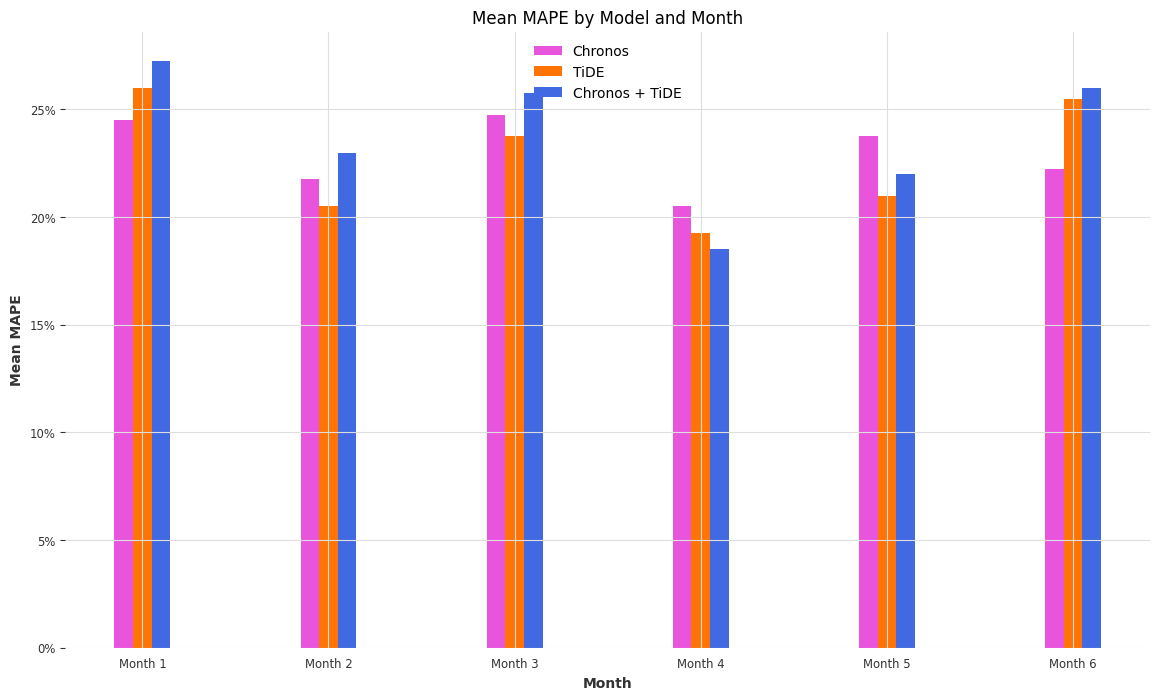

In [13]:
utils.plot_model_comparison(["Chronos", "TiDE", "Chronos + TiDE"],
                            [chronos_forecasts, tide_forecasts, hybrid_forecasts_default],
                            tests, FORECAST_HORIZON,TARGET,
                            top = top_25)

Tuned TiDE model predicting the residuals:

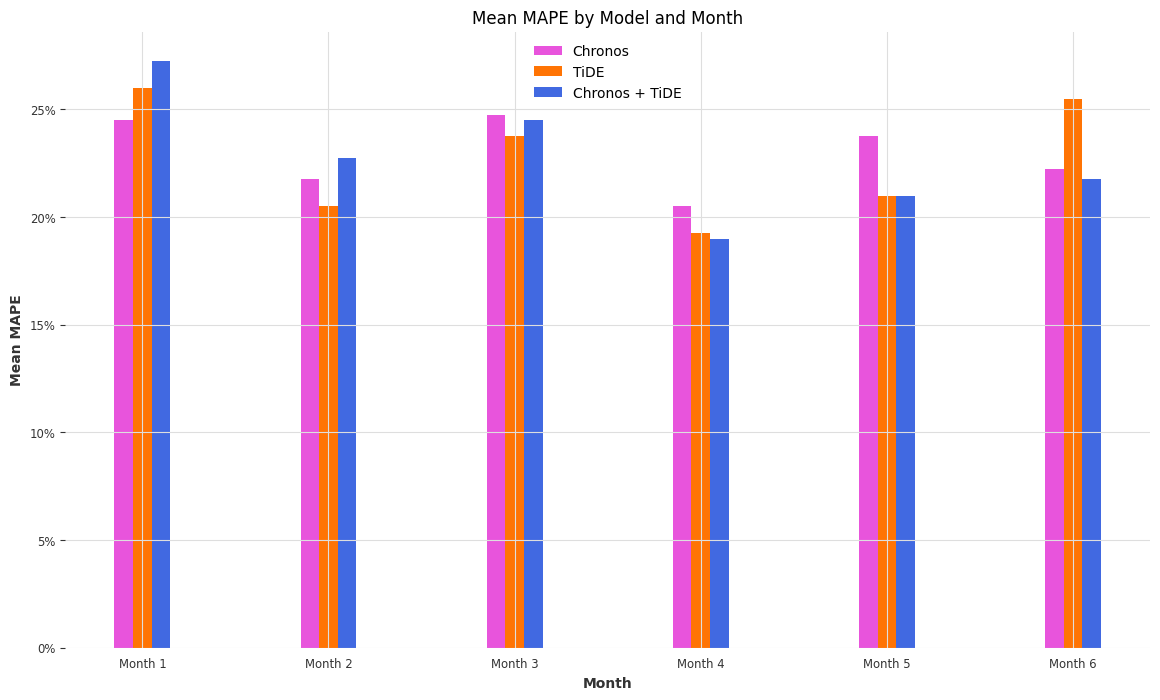

In [14]:
utils.plot_model_comparison(["Chronos", "TiDE", "Chronos + TiDE"],
                            [chronos_forecasts, tide_forecasts, hybrid_forecasts_tuned],
                            tests, FORECAST_HORIZON, TARGET,
                            top = top_25)